<a href="https://colab.research.google.com/github/BuddhikaRoshan/Deep-Learning-Assignment/blob/Heshani/IT22570758.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn import metrics

from zipfile import ZipFile
import cv2
import gc
import os

import tensorflow as tf
from tensorflow import keras
from keras import layers

import warnings
warnings.filterwarnings('ignore')

In [ ]:
data_path = '/content/drive/MyDrive/Deep_Learning_Final_Assignment/lung_images.zip'

with ZipFile(data_path,'r') as zip:
  zip.extractall()
  print('The data set has been extracted.')

In [ ]:
path = 'lung_images'
classes = ['lung_n', 'lung_aca']

for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)

    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [ ]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 20
BATCH_SIZE = 64

X = []
Y = []

for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')

  for image in images:
    img = cv2.imread(image)

    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)

X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size=SPLIT, random_state=2022)

In [ ]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32,
                  kernel_size=(5, 5),
                  activation='relu',
                  input_shape=(IMG_SIZE,
                               IMG_SIZE,
                               3),
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=64,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(filters=128,
                  kernel_size=(3, 3),
                  activation='relu',
                  padding='same'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(2, activation='softmax')
])
model.summary()


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True


es = EarlyStopping(patience=3,
                   monitor='val_accuracy',
                   restore_best_weights=True)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=2,
                       factor=0.5,
                       verbose=1)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
history = model.fit(X_train, Y_train,
                    validation_data = (X_val, Y_val),
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    verbose = 1,
                   )

Epoch 1/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 112s 7s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.5375 - val_loss: 4.8628
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 138s 7s/step - accuracy: 1.0000 - loss: 8.4246e-04 - val_accuracy: 0.9167 - val_loss: 0.3166
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 1.0000 - loss: 8.8633e-04 - val_accuracy: 0.7708 - val_loss: 0.9787
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 1.0000 - loss: 6.4363e-04 - val_accuracy: 0.9500 - val_loss: 0.1729
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 108s 7s/step - accuracy: 1.0000 - loss: 4.5098e-04 - val_accuracy: 0.9667 - val_loss: 0.1371
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 7s/step - accuracy: 1.0000 - loss: 4.0726e-04 - val_accuracy: 0.9750 - val_loss: 0.1503
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 143s 7s/step - accuracy: 1.0000 - loss: 4.0716e-04 - val_accuracy: 0.9625 - val_loss: 0.2666
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 1.0000 - loss: 0.0014 - 

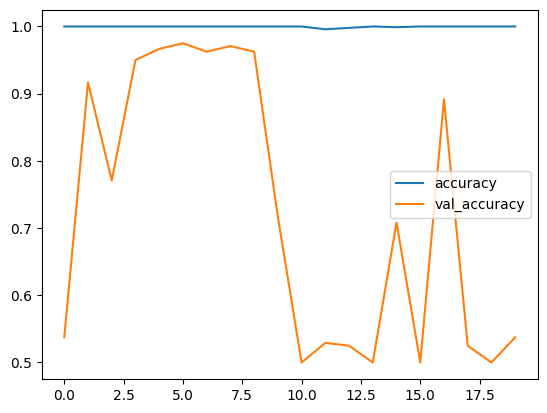

In [15]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [16]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)
print(metrics.classification_report(Y_val, Y_pred,
                                    target_names=classes))

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 962ms/step
              precision    recall  f1-score   support

      lung_n       1.00      0.07      0.14       120
    lung_aca       0.52      1.00      0.68       120

    accuracy                           0.54       240
   macro avg       0.76      0.54      0.41       240
weighted avg       0.76      0.54      0.41       240

